# 確認テスト第2回

* 100点満点, 2問必答です。
* 制限時間は60分です。
* 使用してよいもの
 - 任意のプログラミング言語および任意のパッケージを用いてよい。
 - インターネットで不明点を検索して良い。

## 第1問

`./data` directoryに`infant_mortality_train.csv`と名前のcsvファイルが入っています。このファイルには、

* 国名
* GDP
* 乳児死亡率

がレコードされています。このデータを用いてGDPから乳児死亡率を予測するモデルを作ることになりました。

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
train = pd.read_csv('infant_mortality_train.csv')

print(train.shape)
train.head()

(159, 3)


,国名,GDP,乳児死亡率
0,Afghanistan,2848.0,154.0
1,Albania,863.0,32.0
2,Algeria,1531.0,44.0
3,Andorra,NaN,NaN
4,Angola,355.0,124.0


1. 事前調査として、以下の2つを調べてください。
 - レコードされている国の数
 - GDPか乳児死亡率のいずれかに欠損のある国の数

In [10]:
print(train.shape[0])

159


In [12]:
train_dropna = train.dropna()
print(train.shape[0] - train_dropna.shape[0])

11


2. データを理解するために、以下の2つを計算してください。
 - GDPと乳児死亡率との間の散布図を描き、相関係数を計算してください。
 - GDP, 乳児死亡率ともに対数をとった場合に、散布図を描いて相関係数を計算してください。

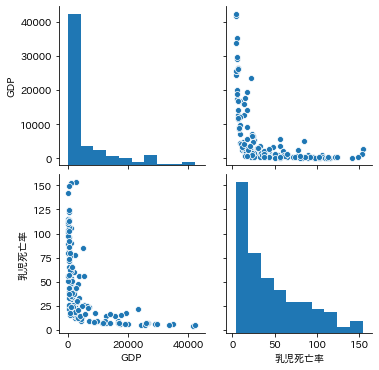

In [13]:
sns.pairplot(train_dropna[['GDP', '乳児死亡率']])
plt.show()

In [14]:
print(train_dropna[['GDP', '乳児死亡率']].corr())

            GDP     乳児死亡率
GDP    1.000000 -0.533434
乳児死亡率 -0.533434  1.000000


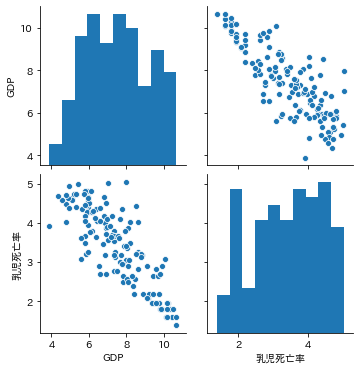

In [15]:
sns.pairplot(train_dropna[['GDP', '乳児死亡率']].apply(np.log))
plt.show()

In [16]:
print(train_dropna[['GDP', '乳児死亡率']].apply(np.log).corr())

            GDP     乳児死亡率
GDP    1.000000 -0.837786
乳児死亡率 -0.837786  1.000000


3. GDPの対数から乳児死亡率の対数を予測するモデルを線形回帰モデルで作ることにしました。この場合、線形回帰モデルは以下のような式で表されます。
\begin{align*}
\log(乳児死亡率) &= \beta_{0}+\beta_{1}\log(GDP)+誤差
\end{align*}
$\beta_{0}$は切片、$\beta_{1}$は回帰係数と呼ばれるものです。この2つの推定値を計算してください。

4. 作ったモデルを以下の式で評価することにしました。
\begin{align*}
R^2 &= 1-\sum_{i=1}^{n}\frac{(y_{i}-\hat{y}_{i})^2}{(y_{i}-\bar{y})^2}
\end{align*}
ここで、$y_{i}$はdatapoint $i$の乳児死亡率、$\hat{y}_{i}$はdatapoint $i$の乳児死亡率の予測値、$\bar{y}$はデータ全体での乳児死亡率の標本平均値です。
 - 評価指標$R^2$を`infant_mortality_train.csv`で計算してください。
 - `./data` directoryには`infant_mortality_test.csv`というcsvファイルが準備されています。このデータを用いて改めて評価指標$R^2$を計算してください。

In [28]:
X_train = train_dropna[['GDP']].apply(np.log)
y_train = train_dropna['乳児死亡率'].apply(np.log)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

pred_train = linreg.predict(X_train)

print('train r2_score: {:.3f}'.format(r2_score(train_dropna['乳児死亡率'], np.exp(pred_train))))

train r2_score: 0.434


In [29]:
test = pd.read_csv('infant_mortality_test.csv')

pred_test = linreg.predict(np.log(test[['GDP']]))

print('test r2_score: {:.3f}'.format(r2_score(test['乳児死亡率'], np.exp(pred_test))))

test r2_score: 0.264


## 第2問

`./data` directoryに`flowcytometry.csv`と名前のcsvファイルが入っています。このファイルには、血液細胞にレーザーを当てた際に得られる4つの結果

* FL1.H
* FL2.H
* FL3.H
* FL4.H

がレコードされています。このデータを基に血液細胞をクラスタリングしてみましょう。

In [30]:
train = pd.read_csv('flowcytometry.csv')

print(train.shape)
train.head()

(17532, 4)


,FL1.H,FL2.H,FL3.H,FL4.H
0,535.857117,17.818647,596.661865,191.029587
1,0.000000,98.526642,33.853153,58.457142
2,611.634949,124.730530,342.763184,201.468368
3,286.873016,31.444672,120.601860,191.029587
4,124.492065,0.000000,0.000000,177.459183


1. 事前調査として、データにレコードされている行数を求めてください。

In [31]:
print(train.shape[0])

17532


2. データを理解するために、以下の2つの問いに答えてください。
 - 4変数間の散布図を描いてください。
 - 各変数を標準化しておき、主成分分析を用いて2次元に次元圧縮した結果を散布図で図示してください。

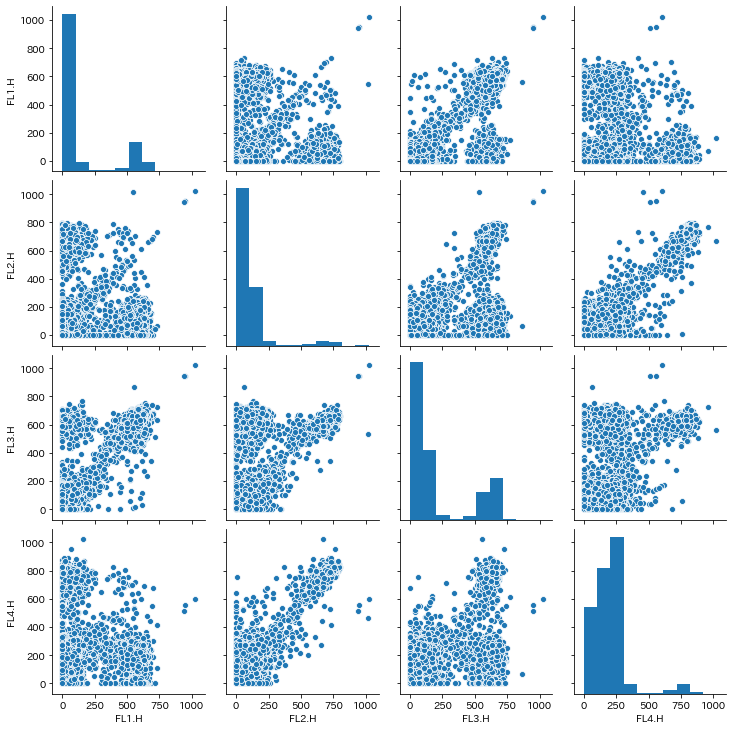

In [32]:
sns.pairplot(train)
plt.show()

(17532, 2)


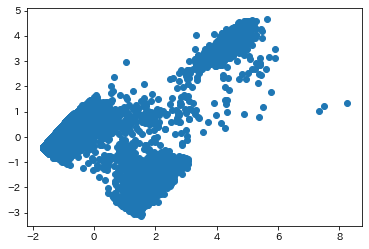

In [46]:
std = StandardScaler()
X_train = std.fit_transform(train)

# 特徴量を4つから2つに次元削減する
pca = PCA(n_components=2)
X_new = pca.fit_transform(X_train)
print(X.shape)

plt.scatter(X_new[:, 0], X_new[:, 1])
plt.show()

3. 主成分分析で次元圧縮して得た2変数に対して以下の計算をおこなってください。
 - K-Means法を実行し、3つのクラスターにデータを分割してください。
 - 次元圧縮して得た2変数の散布図を描き、クラスターごとに色分けしてください。

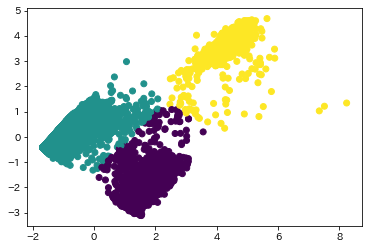

In [47]:
kmeans = KMeans(n_clusters=3)
kmeans.fit_transform(X_new)

cluster = kmeans.predict(X_new)

plt.scatter(X_new[:, 0], X_new[:, 1], c=cluster)
plt.show()

## ボーナス問題

第1問と同じ課題を考えましょう。要するに、`infant_mortality_train.csv`というデータを用いてGDPから乳児死亡率を予測するモデルを作ります。作った予測モデルは`infant_mortality_test.csv`というデータの上で評価することとし、特に

\begin{align*}
R^2 &= 1-\sum_{i=1}^{n}\frac{(y_{i}-\hat{y}_{i})^2}{(y_{i}-\bar{y})^2}
\end{align*}

が0.6以上になるモデルを作ってください。（使う機械学習モデルは、既習範囲のものにこだわらない。また外部のデータを用いてはならない。）

なお、モデルの提出にあたっては、`infant_mortality_test.csv`を用いて適切に計算された$R^2$の値のみを提出すること。

In [81]:
X_train = train_dropna[['GDP']]
y_train = train_dropna['乳児死亡率']

In [82]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

RandomForestRegressor()

In [83]:
X_test = train_dropna[['GDP']]
y_test = train_dropna['乳児死亡率']

pred_test = rfr.predict(X_test)

print('r2_score: {:.3f}'.format(r2_score(y_test, pred_test)))

r2_score: 0.883
